### XGBoost CatBoost Baseline - CV 0.688 - LB 0.688

In [1]:
!pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

Processing /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
  Preparing metadata (setup.py) ... - done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=1694dad1484e2c736079b12db6254481378545702d82bf6b4e64df6158bd35bb
  Stored in directory: /root/.cache/pip/wheels/6b/b5/e0/4c79e15c0b5f2c15ecf613c720bb20daab20a666eb67135155
Successfully built autograd-gamma
Processing /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl


In [2]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")

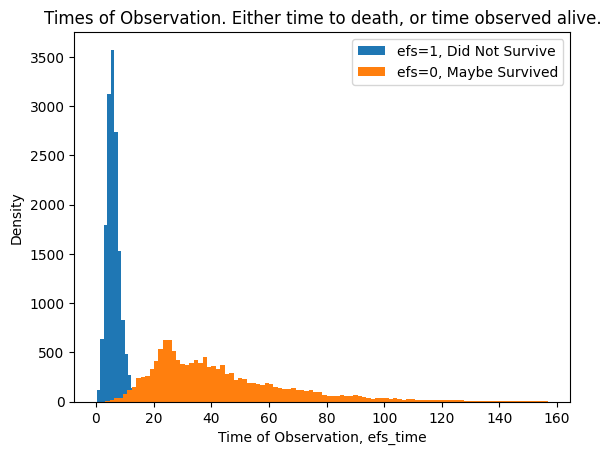

In [3]:
# 'efs==1' => 死亡、'efs==0' => 'efs_time'以上生存
plt.hist(train.loc[train.efs==1,"efs_time"],bins=100,label="efs=1, Did Not Survive")
plt.hist(train.loc[train.efs==0,"efs_time"],bins=100,label="efs=0, Maybe Survived")
plt.xlabel("Time of Observation, efs_time")
plt.ylabel("Density")
plt.title("Times of Observation. Either time to death, or time observed alive.")
plt.legend()
plt.show()

### 訓練データの目的2変数を1つに統合する
`efs` と `efs_time` を変換して一つにまとめる.

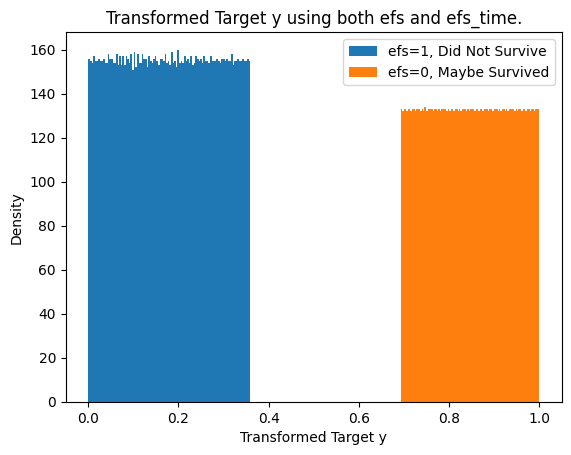

In [4]:
# 生存者と死亡者の分布を見るため
train["y"] = train.efs_time.values

# 死亡者の最長寿命
mx = train.loc[train.efs==1,"efs_time"].max()
# 生存者の最短寿命
mn = train.loc[train.efs==0,"efs_time"].min() # 生存者の寿命の最小値

# 生存者のy値を死亡者のy値とスケール合わせる
train.loc[train.efs==0,"y"] = train.loc[train.efs==0,"y"] + mx - mn
# ランク付けによりy値に順位を付ける
train.y = train.y.rank()

# 生存者を死亡者と違う離れたスケールに位置させるため
train.loc[train.efs==0,"y"] += len(train)//2
train.y = train.y / train.y.max()

plt.hist(train.loc[train.efs==1,"y"],bins=100,label="efs=1, Did Not Survive")
plt.hist(train.loc[train.efs==0,"y"],bins=100,label="efs=0, Maybe Survived")
plt.xlabel("Transformed Target y")
plt.ylabel("Density")
plt.title("Transformed Target y using both efs and efs_time.")
plt.legend()
plt.show()

### 特徴量
カテゴリ変数 = 35、数値変数 = 22、数値列はNaNとする。

In [5]:
RMV = ["ID","efs","efs_time","y"]
FEATURES = [c for c in train.columns if not c in RMV] # RMV以外の特徴量
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [6]:
# カテゴリ変数をCATSにまとめる。欠損はNANで埋める
CATS = []
for c in FEATURES:
    if train[c].dtype=="object":
        CATS.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

In these features, there are 35 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']


In [7]:
# 行方向に train と test を結合
combined = pd.concat([train,test],axis=0,ignore_index=True)

print("カテゴリ変数をラベルエンコードする: ",end="") # 改行しない
for c in FEATURES:

    # ラベルエンコードし int32 に変換する
    if c in CATS:
        print(f"{c}, ",end="")
        combined[c],_ = combined[c].factorize() # ラベルエンコード
        combined[c] -= combined[c].min() # 最小値で引く
        combined[c] = combined[c].astype("int32")
        combined[c] = combined[c].astype("category")
        
    # 数値は精度を落としてメモリ節約する
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")

# ラベルエンコード後、訓練データとテストデータを行抽出で元に戻す
train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

カテゴリ変数をラベルエンコードする: dri_score, psych_disturb, cyto_score, diabetes, tbi_status, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, 

In [8]:
# LightGBMでスコアを算出
from sklearn.model_selection import KFold
from xgboost import XGBRegressor, XGBClassifier
import xgboost
# print("Using XGBoost version",xgboost.__version__)
import lightgbm as lgb

# LGBMパラメータ
lgbm_params = {
    "task": "train",
    "objective": "regression",
    "boosting": "gbdt",
    # "num_boost_round": 100,
    "learning_rate": 0.1,
    "device_type": "gpu",
    "seed": 1234,
    "metric": "l1",
}

In [9]:
%%time
FOLDS = 5 # 分割数
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_lgb = np.zeros(len(train)) # 検証予測結果(valid)
pred_lgb = np.zeros(len(test)) # 目的予測結果(test)

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # test_index = 1/5行、train_index = 4/5行
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習。評価関数MAEが最小になるように学習 (検証データ = eval)
    model_lgb = lgb.train(lgbm_params,
                         lgb_train,
                         valid_sets = lgb_eval,
                         callbacks=[
                             lgb.early_stopping(stopping_rounds=10,
                                                verbose=-1)], )
    # 予測
    y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)    
    
    oof_lgb[test_index] = model_lgb.predict(x_valid)
    pred_lgb += model_lgb.predict(x_test)

# 平均評価
pred_lgb /= FOLDS

#########################
### Fold 1
#########################
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 842
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 36 dense feature groups (0.79 MB) transferred to GPU in 0.002312 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.485943
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.273302
#########################
### Fold 2
#########################
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 840
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 36 dense feature groups (0.79 MB) transferred to GPU in 0.002509 secs. 1 sparse feature groups
[LightGBM] [Info] Start tr

In [10]:
from metric import score

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
# KF × 3で全部埋めた
y_pred["prediction"] = -oof_lgb
# スコアの付け方は難しいので結果ありきで進める
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for LightGBM =",m)

/kaggle/usr/lib/eefs-concordance-index/metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for LightGBM = 0.660351393120953


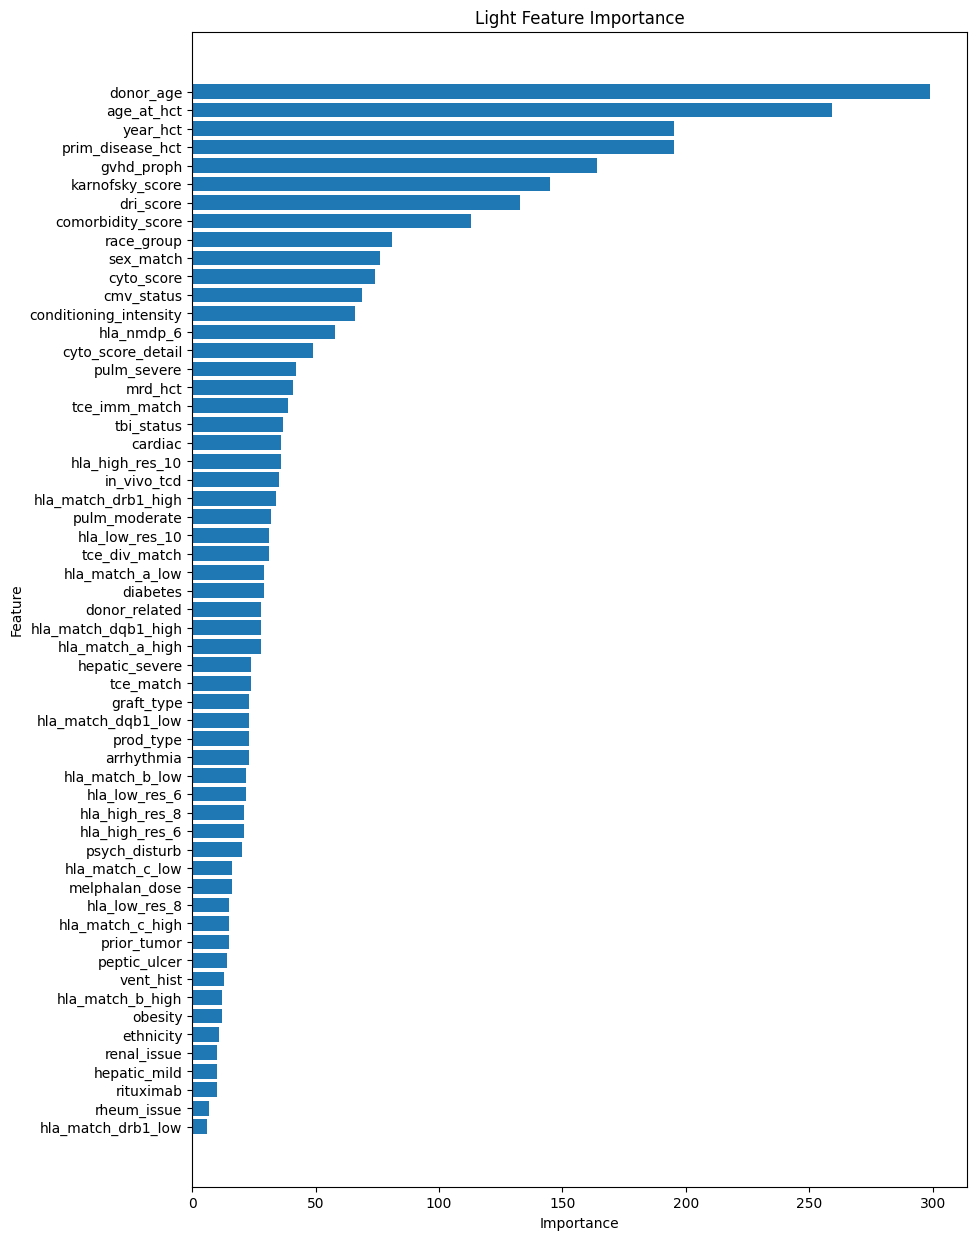

In [11]:
# 特徴量の寄与率を高い順に示す
feature_importance = model_lgb.feature_importance()
importance_df = pd.DataFrame({
    "Feature": FEATURES,  # 特徴量
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Light Feature Importance")
plt.gca().invert_yaxis()  # 下り順表示
plt.show()

### 提出ファイル作成

In [12]:
# csv出力
sub = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")
sub.prediction = -pred_lgb
sub.to_csv("submission.csv",index=False)
print("Sub shape:",sub.shape)
sub.head()

Sub shape: (3, 2)


,ID,prediction
0,28800,-0.785894
1,28801,-0.450502
2,28802,-0.740307
